# Importing Dependecies

In [1]:
"""
Base
"""
import pandas as pd
import numpy as np

import math as math
import geopandas as gpd
from dotenv import load_dotenv
import os
import json

DATA_PATH = os.getenv("DATA_PATH")
SAVE_PATH = os.getenv("RESULTS_PATH")
FULL_PAGE_WIDTH_CM = float(os.getenv("FULL_PAGE_WIDTH_CM"))
FULL_PAGE_LENGTH_CM = float(os.getenv("FULL_PAGE_LENGTH_CM"))
load_dotenv()

"""
Geospatial analysis libraries
"""
import momepy
import shapely as shapely


"""
Network training libraries
"""
import torch


from torch.utils.data import DataLoader
from tqdm import tqdm


"""
Plotting Libraries
"""
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
from matplotlib.lines import Line2D
import matplotlib.colors as mcolors
import seaborn as sns

In [2]:
from src.loading_datasets import loading_brussels_shape,loading_separated_bike_infrastructure
from src.plotting_utilities import cm_to_inches, setup_plotting
label_font, tick_font, title_font, legend_font = setup_plotting()
from src.network import MultiHeadNetwork

# Importing datasets & Functions

In [ ]:
brussels_region, brussels_municipalities = loading_brussels_shape()

"""
Loading total strava dataset
"""
strava_total_2024 = pd.read_csv(f'{DATA_PATH}/strava_edge_data/strava_edge_total_enhanced_2024.csv')
strava_total_2024['date'] = pd.to_datetime(strava_total_2024['date'])
strava_total_2024['strava_trips_normalised'] = strava_total_2024['strava_trips_normalised'].astype(float)
"""
Loading strava edge shapefile
"""
strava_edge_shape = gpd.read_file(f'{DATA_PATH}/strava_edge_data/strava_edges.shp').to_crs('epsg:31370')
strava_edge_shape.rename(columns = {'edgeUID':'edge_uid'},inplace=True)
"""
Loading separated bike infrastructure
"""
bike_infra_separated = loading_separated_bike_infrastructure()

"""
Making sure boolean columns are boolean and edge_uid and osmId are int
"""
edges_with_infra = gpd.read_file(f"{SAVE_PATH}/datasets/strava_edges_with_infra_final_iteration.csv", GEOM_POSSIBLE_NAMES="geometry", KEEP_GEOM_COLUMNS="NO") 
edges_with_infra.crs = 'epsg:31370'
for column in edges_with_infra.columns:
    if column not in ['edgeUID','osmId','geometry']:
        edges_with_infra[column] = edges_with_infra[column].astype(str).map({'False':False, 'True':True})

edges_with_infra.rename(columns={'edgeUID': 'edge_uid'}, inplace=True)
edges_with_infra['edge_uid'] = edges_with_infra['edge_uid'].astype(str).astype(int)
edges_with_infra['osmId'] = edges_with_infra['osmId'].astype(str).astype(int)

# Merge all sep_it_* columns into one boolean column: True if any is True
sep_cols = edges_with_infra.filter(regex=r'^sep_it_').columns
edges_with_infra['separated_bike_infrastructure_any'] = edges_with_infra[sep_cols].fillna(False).any(axis=1)



In [8]:
additional_true = [160227334,160227327,160227326,160227273,160227271,160227056,160227268,160228420,160193296,160193310,160364498,160364514,160364091,160364074,160364496,160380574,160380577,
                   160380583,160380584,160380587,160380586,160408902,160408872,160410405,160410404,160410403,160410408,160410372,160410377,160410411,160410409,160410413,160410407,
                   160226580,160226570,160226577,160226518,160226715,160226731,160226722,160226828,160226833,160226738,160226739,160226745,160226719,160226576,160226565,
                   160302119,160301782,160301781,160301777,160301776,160302553,160302101,160302102,160302112,160301916,160301780,160302436,160301773,160301774,160302438,160411046,
                   160411026,160411025,160411021,160411020,160411018,160411016,160411015,160410638,160410640,160410636,160410631,160410622,160410620,160410618,160381949,160381948,160381940,160381939,160411060,160381930,160411067,160411069,160411065,
                   160411206,160411063,160381889,160381928,160411048,
                   160177442,160177520,160177523,160177502,160191586,160191956,160191970,160195482,160195426,160363137,160230070,160299520,160320554,160320549,160177468,160191945,
                   160193288,160195498,160193998,160194004,160194003,160194002,160352325,160352321,160353553,160365932,
                   160242027,160242028,160177549,160177546,160177538,160177535,160177532,160177533,160175344,160177428,
                   160230444,160230450,160230550,160230565,160230569,160230567,160230573,160230571,160230577,160230575
                   ]

additional_false = [160363182,160363184,160363183,160363089,160191898,160301783,160301784,160302590,160301753,160381943,160381942,160410619,160410634,160410635,160410621,160410626,160410624,160410627,160410623,160410632,
                    160381890,160381885,160381929,160411039,160410639,160381888,160381858,160410630,
                    160241780,160271743,160191524,160191525,160288896,160288895,160288897,160320606,160320601,160320600,160321326,160320613,160320614,160321016,160321017,160321194,160321179,160321082,160321167,
                    160321169,160321099,160321089,160321087,160321154,160321148,160321133,160274870,160274875,160274888,160274886,160274872,160274884,160274892,160275365,160275366,160274868,
                    160274874,160274793,160274781,160274780,160274905,160274893,160274894,160213616,160213676,160213677,160213666,160213668,160213553,160213555,160213617,160194008,160365818,160365822,
                    160177534,160177550
                    ]
 

for edge_uid in additional_true:
    if edges_with_infra[edges_with_infra['edge_uid'] == edge_uid]['separated_bike_infrastructure_any'].item() == False:
        edges_with_infra.at[edges_with_infra[edges_with_infra['edge_uid'] == edge_uid].index.item(), 'separated_bike_infrastructure_any'] = True

for edge_uid in additional_false:
    if edges_with_infra[edges_with_infra['edge_uid'] == edge_uid]['separated_bike_infrastructure_any'].item() == True:
        edges_with_infra.at[edges_with_infra[edges_with_infra['edge_uid'] == edge_uid].index.item(), 'separated_bike_infrastructure_any'] = False

In [9]:
def top30_strokes_iterative(
        edges_full: gpd.GeoDataFrame,
        n_start: int = 300,
        n_step: int = 100,
        length_min: float = 250,
        max_iter: int = 20,
        verbose: bool = True,
):
    """
    Iteratively adds the next `n_step` most-trafficked edges, rebuilds COINS strokes,
    and stops when the 30 busiest ≥ length_min strokes are stable.

    Returns
    -------
    strokes_gdf : GeoDataFrame
        Geometry + attributes of the final top-30 strokes.
    edges_gdf   : GeoDataFrame
        All edges that belong to those strokes (complete geometry).
    """

    # 0 ── prepare a view of edges sorted by volume
    edges_sorted = edges_full.sort_values("strava_trips", ascending=False).reset_index(drop=True)

    # book-keeping
    prev_top_ids = set()
    used_n = n_start
    count = 0
    for it in tqdm(range(1, max_iter + 1)):
        candidate_edges = edges_sorted.head(used_n).copy()

        # 1 ── build strokes on current subset
        coins = momepy.COINS(candidate_edges,angle_threshold= 160)
        candidate_edges["stroke_index"] = coins.stroke_attribute().values
        stroke_gdf = coins.stroke_gdf()
        stroke_gdf["length"] = stroke_gdf.length  

        
        # 2 ── aggregate traffic per stroke + filter by length
        stroke_stats = (
            candidate_edges.groupby("stroke_index")["strava_trips"]
                           .median()
                           .to_frame("median_total_strava_trips")
                           .join(stroke_gdf["length"])
        )
        top30 = (stroke_stats.query(f"length > {length_min}")
                            .nlargest(30, "median_total_strava_trips"))

        top_ids = set(top30.index)
        
        if verbose:
            print(f"iter {it:>2}: edges = {used_n:>4}  "
                  f"unique strokes = {len(stroke_stats):>5}  "
                  f"top-30 stable = {top_ids == prev_top_ids}")

        # 3 ── stop when top set unchanged
        if top_ids == prev_top_ids:
            count += 1
        else:
            count = 0

        prev_top_ids = top_ids
        used_n += n_step                             # grow the subset and repeat
        if count >= 1:                     # stop after 3 iterations of stability
            break

    # 4 ── once stable, pull *all* edges that belong to the final strokes
    final_edges = edges_full[edges_full.edge_uid.isin(
                     candidate_edges[candidate_edges.stroke_index.isin(top_ids)].edge_uid)
                 ].copy()
    final_edges['stroke_index'] = final_edges['edge_uid'].map(candidate_edges.set_index('edge_uid')['stroke_index'])
    final_strokes = stroke_gdf.loc[list(top_ids)].copy()
    # attach stats you might want
    final_strokes = final_strokes.join(
    stroke_stats.loc[list(top_ids), ["median_total_strava_trips"]]   # ← no duplicate column anymore
)

    return final_strokes, final_edges

# Figure: Infrastructure edges overlayed

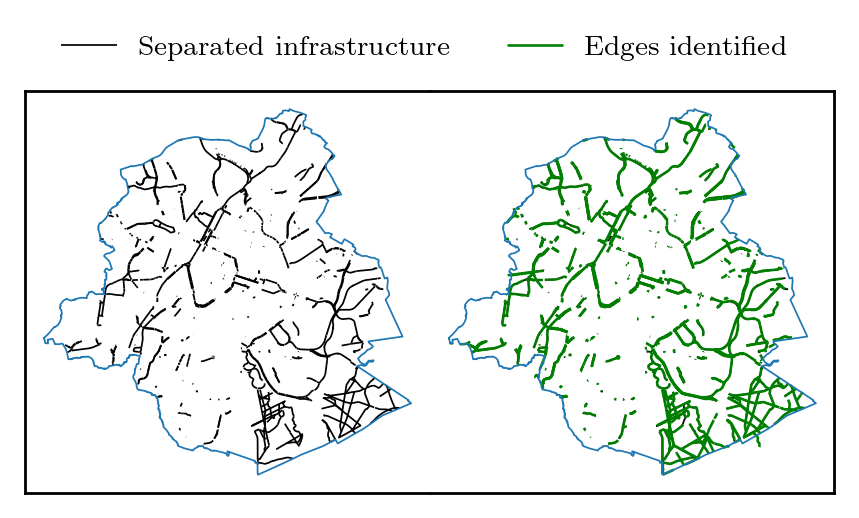

In [10]:
fig_infrastructure,ax_infrastructure = plt.subplots(1,2,figsize = (cm_to_inches(FULL_PAGE_WIDTH_CM),cm_to_inches(FULL_PAGE_WIDTH_CM/3)), dpi = 250,gridspec_kw={'wspace': -0.5})


brussels_region.boundary.plot(ax = ax_infrastructure[0],linewidth = 0.5)
bike_infra_separated.plot(ax = ax_infrastructure[0],color = 'black',zorder = 0,linewidth =0.5,label = 'separated \n infrastructure')
_ = ax_infrastructure [0].set_xticks([])
_ = ax_infrastructure[0].set_yticks([])


brussels_region.boundary.plot(ax = ax_infrastructure[1],linewidth = 0.5)
bike_infra_separated.plot(ax = ax_infrastructure[1],color = 'black',zorder = 0,linewidth =0.5,label = 'Separated infrastructure')

edges_with_infra[edges_with_infra['separated_bike_infrastructure_any']].plot(ax = ax_infrastructure[1],color = 'green',zorder = 1,linewidth =0.75,label = 'Edges identified')

_ = ax_infrastructure [1].set_xticks([])
_ = ax_infrastructure[1].set_yticks([])


ax_infrastructure[0].spines['right'].set_visible(False)
ax_infrastructure[1].spines['left'].set_visible(False)

leg = ax_infrastructure[1].legend(loc = 'upper right',bbox_to_anchor=(0.95, 1.2),frameon = False,edgecolor = 'black',fontsize = legend_font['fontsize'],ncols = 2)

fig_infrastructure.savefig(f"{SAVE_PATH}/figures/main/figure_4_infrastructure_stravaedges_overlay.pdf")


# Finding High-Traffic Strokes

In [11]:
make_file = False
if make_file:
    edges_no_infra_df =edges_with_infra[edges_with_infra["separated_bike_infrastructure_any"] == False].copy()

    edges_no_infra_df['in_brussels'] = None
    edges_no_infra_df['in_brussels'] = edges_no_infra_df['geometry'].apply(lambda x: x.within(brussels_region.geometry))

    edges_no_infra_df = edges_no_infra_df[edges_no_infra_df['in_brussels']]
else:
    edges_no_infra_df = gpd.read_file(f"{DATA_PATH}/strava_edge_data/strava_edges_without_infrastructure.shp")

In [12]:
edges_no_infra_counts_2024_df = strava_total_2024[(strava_total_2024["edge_uid"].isin(edges_no_infra_df["edge_uid"]))].copy(deep = True)
edges_no_infra_counts_2024_df_grouped = edges_no_infra_counts_2024_df.groupby(['edge_uid'])[['strava_trips']].sum().reset_index()

In [13]:
top30_strokes, top30_edges = top30_strokes_iterative(
    edges_full=edges_no_infra_df
               .merge(edges_no_infra_counts_2024_df_grouped[['edge_uid', 'strava_trips']], on='edge_uid', how='left')
               .fillna({'strava_trips': 0}),
    n_start = 500,     # first batch
    n_step  = 100,     # growth step
    length_min = 250,  # minimum stroke length
    max_iter = 50,     # maximum number of iterations
)

  4%|▍         | 2/50 [00:00<00:05,  8.52it/s]

iter  1: edges =  500  unique strokes =   131  top-30 stable = False
iter  2: edges =  600  unique strokes =   149  top-30 stable = False


  6%|▌         | 3/50 [00:00<00:06,  7.11it/s]

iter  3: edges =  700  unique strokes =   181  top-30 stable = False
iter  4: edges =  800  unique strokes =   201  top-30 stable = False


 12%|█▏        | 6/50 [00:00<00:06,  6.31it/s]

iter  5: edges =  900  unique strokes =   219  top-30 stable = False
iter  6: edges = 1000  unique strokes =   236  top-30 stable = False


 14%|█▍        | 7/50 [00:01<00:07,  5.74it/s]

iter  7: edges = 1100  unique strokes =   262  top-30 stable = False


 16%|█▌        | 8/50 [00:01<00:07,  5.35it/s]

iter  8: edges = 1200  unique strokes =   287  top-30 stable = False


 18%|█▊        | 9/50 [00:02<00:24,  1.67it/s]

iter  9: edges = 1300  unique strokes =   313  top-30 stable = False


 20%|██        | 10/50 [00:03<00:22,  1.80it/s]

iter 10: edges = 1400  unique strokes =   349  top-30 stable = False


 22%|██▏       | 11/50 [00:03<00:18,  2.12it/s]

iter 11: edges = 1500  unique strokes =   364  top-30 stable = False


 24%|██▍       | 12/50 [00:03<00:15,  2.49it/s]

iter 12: edges = 1600  unique strokes =   383  top-30 stable = False


 26%|██▌       | 13/50 [00:04<00:13,  2.79it/s]

iter 13: edges = 1700  unique strokes =   408  top-30 stable = False


 26%|██▌       | 13/50 [00:04<00:12,  2.93it/s]

iter 14: edges = 1800  unique strokes =   429  top-30 stable = True


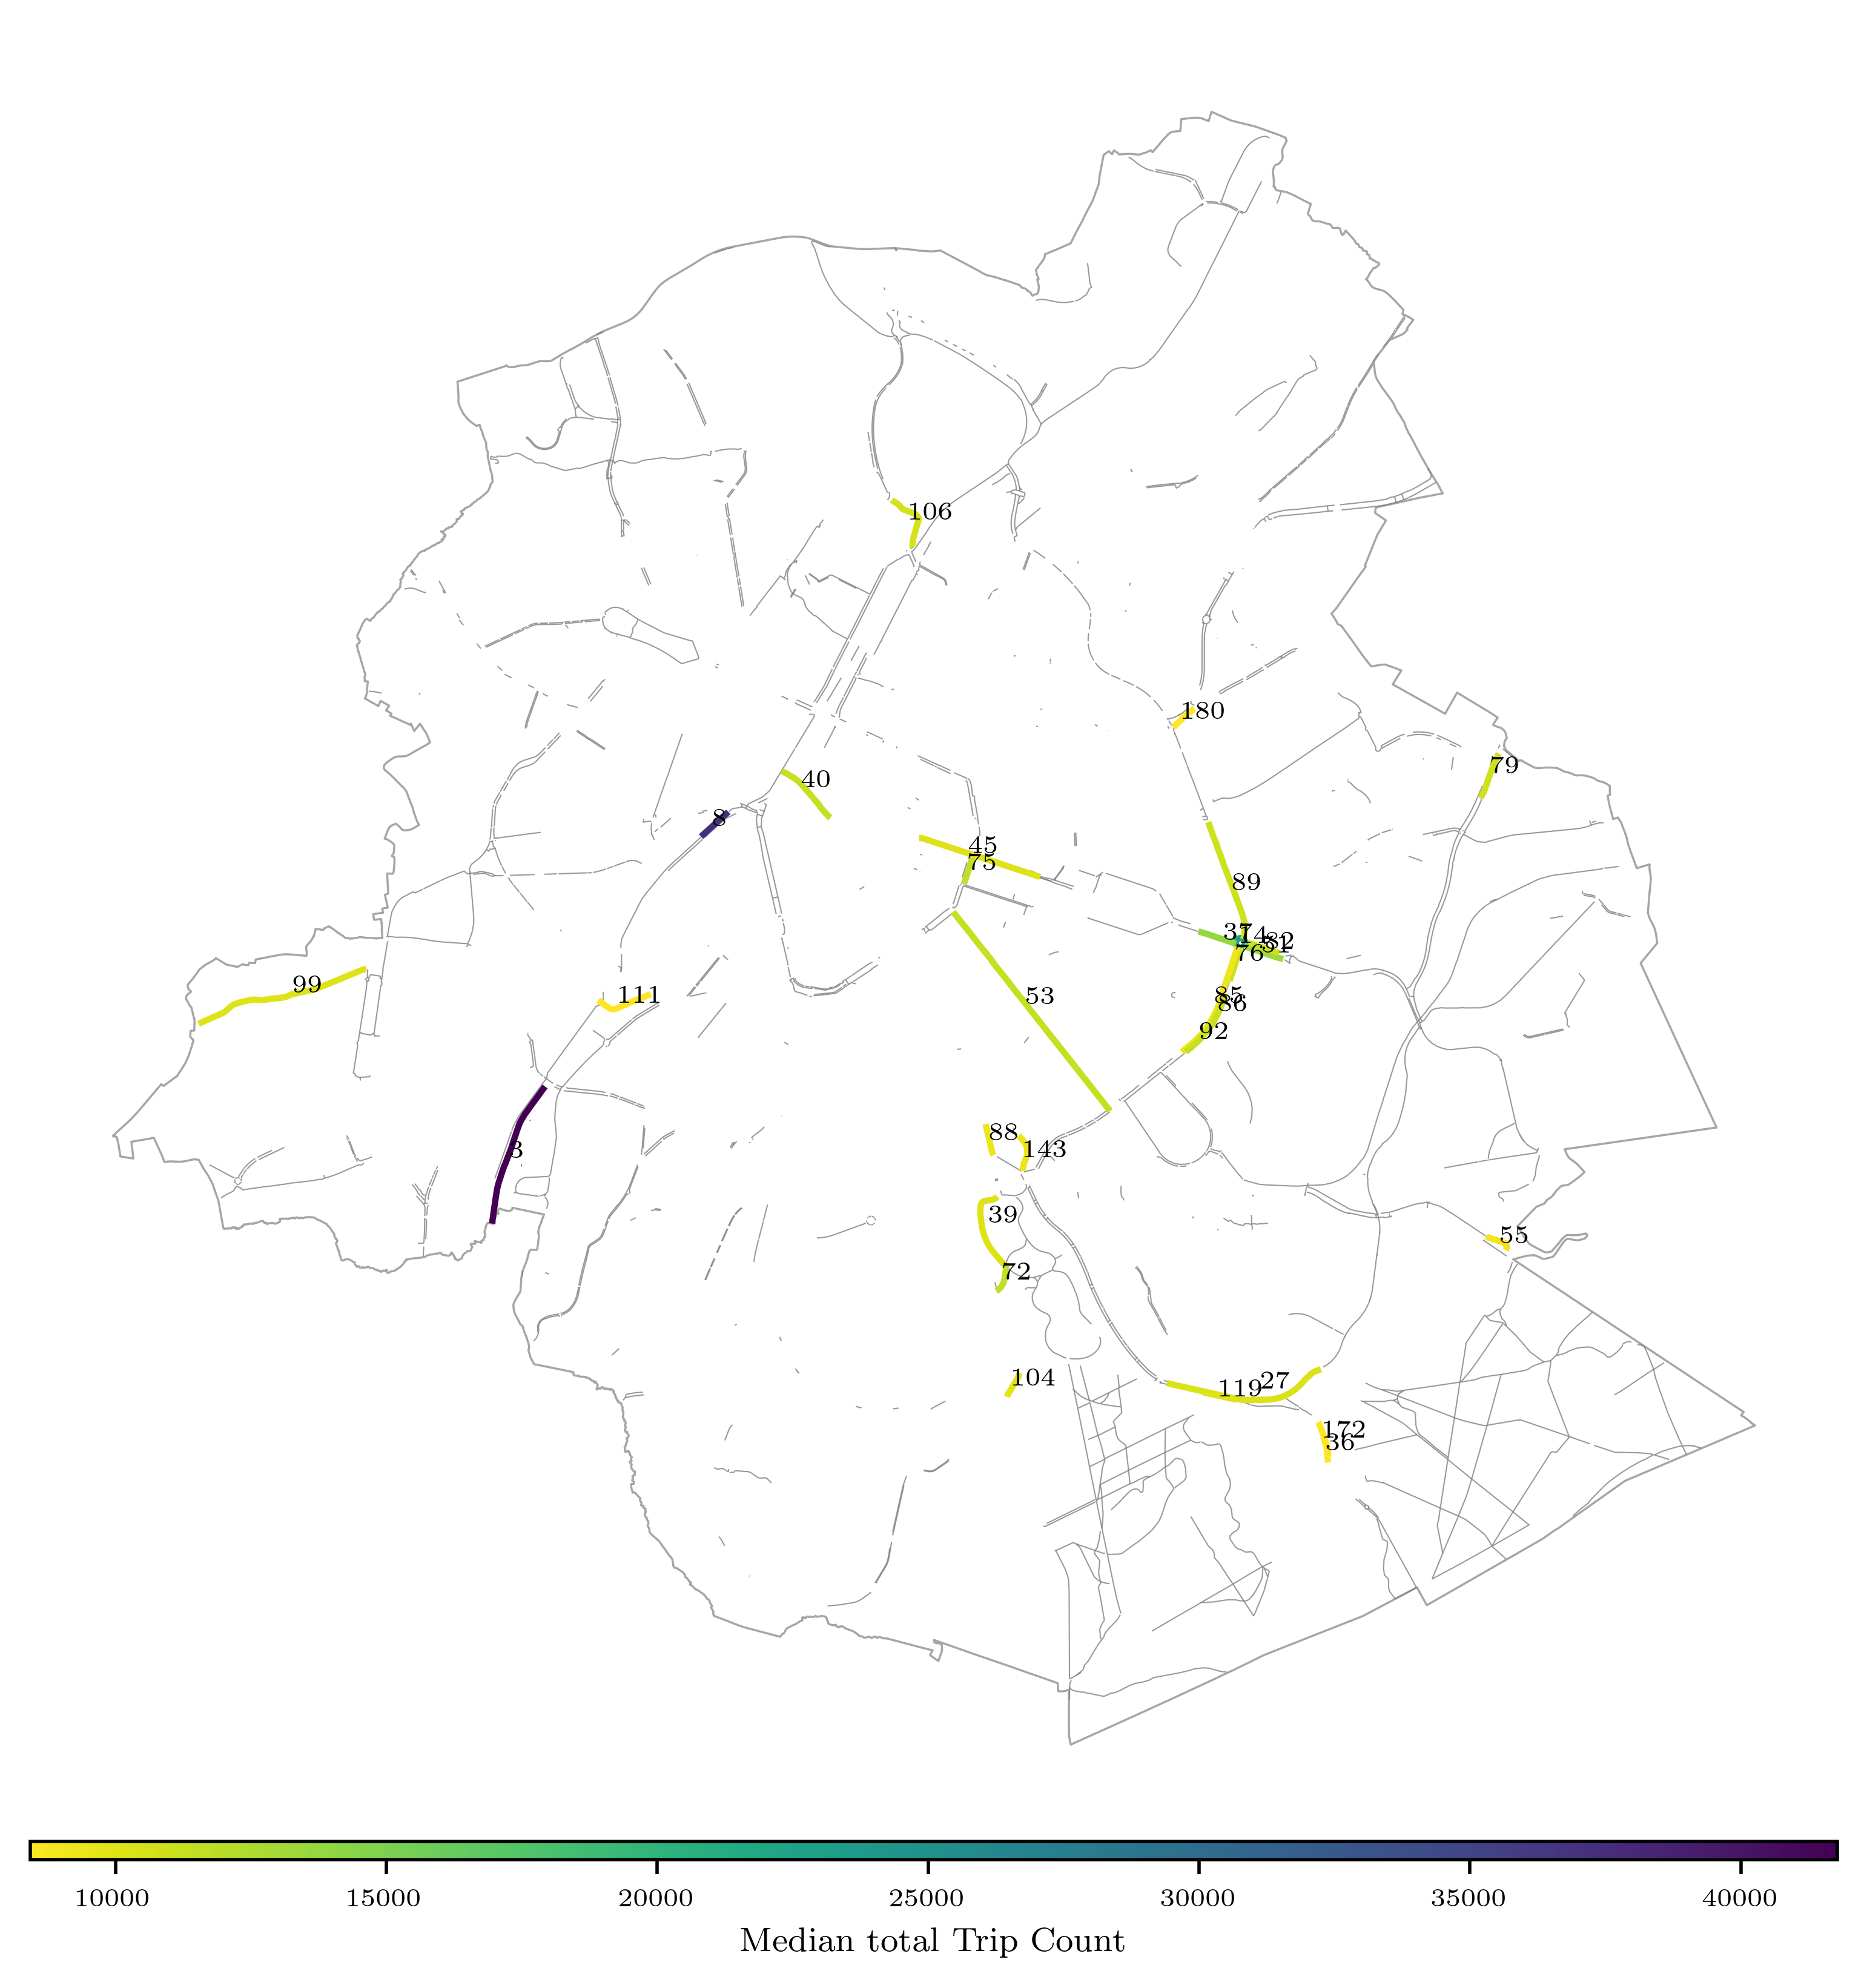

In [14]:
fig, ax = plt.subplots(1,1,figsize = (cm_to_inches(FULL_PAGE_WIDTH_CM),cm_to_inches(FULL_PAGE_LENGTH_CM/0.9)), dpi = 500)   
divider = make_axes_locatable(ax)

cax = divider.append_axes("bottom", size="1%", pad=0.05)

brussels_region.boundary.plot(ax = ax,linewidth = 0.5,color = 'grey',alpha = 0.7)
bike_infra_separated.plot(ax = ax,color = 'grey',zorder = 0,linewidth =0.3,label = 'separated infrastructure',alpha = 0.8)


colorplot = top30_strokes.plot(
    column = 'median_total_strava_trips',
    ax = ax,
    cax = cax,
    cmap="viridis_r",
    linewidth=1.5,
    legend = True,
    legend_kwds={"label": "Median Total Strava Trip Count", "orientation": "horizontal"},
)
for idx, row in top30_strokes.iterrows():
    x,y = row['geometry'].xy

    center_x = sum(x) / len(x)
    center_y = sum(y) / len(y)
    label_x = x[0]
    label_y = y[0]

    ax.text(center_x,center_y,idx,fontsize = 6)


ax.set_xticks([])
ax.set_yticks([])

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

_ = cax.tick_params(labelsize=6)
_ = cax.set_xlabel('Median total Trip Count',fontsize = 8)

pos = cax.get_position()


fig.tight_layout()
fig.savefig(f"{SAVE_PATH}/figures/main/figure_6a_high_traffic_strokes.pdf")


# Extrapolating High-Traffic Strokes

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

from torch.utils.data import Dataset

from collections import defaultdict
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

with open(f"{DATA_PATH}/bike_counters/_max_min_per_counter.json", "rb") as f:
    max_min_per_counter = json.load(f)

In [16]:
strava_col = ['strava_trips_normalised']
cont_cols   = ['temp_avg','precip_quantity','wind_speed_10m']
cyclic_cols = ["month_sin", "month_cos", "wd_sin", "wd_cos","year_normalised", "is_holiday","any_rain"]

In [17]:
def add_lags(df, seq_len, edge_col="edge_uid", date_col="date", count_col="strava_trips_normalised"):
    """
    Adds columns count_t-1 ... count_t-SEQ_LEN per edge.
    - ensure_daily=True will reindex each edge to daily calendar frequency first.
    - fill_missing: "keep" (NaN), "zero", or "ffill" to fill counts before lagging.
    """
    df = df.copy()
    df[date_col] = pd.to_datetime(df[date_col])
    df = df.sort_values([edge_col, date_col])


    # Add lag columns
    for i in range(1, seq_len + 1):
        df[f"{count_col}_t-{i}"] = df.groupby(edge_col, sort=False)[count_col].shift(i)

    return df

SEQ_LEN = 7

strava_total_2024_lagged = add_lags(strava_total_2024, SEQ_LEN)

In [18]:
preprocessor = ColumnTransformer([
    ("pass",  "passthrough",[f'strava_trips_normalised_t-{day}' for day in range(1,SEQ_LEN+1)] + strava_col+cyclic_cols),
    ("scale", StandardScaler(), cont_cols),
    
])

id_idx  = strava_total_2024_lagged["counter_region_index"].values            
X_num   =   preprocessor.fit_transform(strava_total_2024_lagged).astype(np.float32)

In [19]:
ds_fcnn = pd.DataFrame(columns=["X",'id'])

class CustomDataset(Dataset):
    def __init__(self, X,id):
        self.train_vector = X
        self.id = id

    def __len__(self):
        return len(self.train_vector)

    def __getitem__(self, idx):
        sample = self.train_vector[idx]
        id = self.id[idx]
        
        return sample,id
    

ds_fcnn = pd.DataFrame({
    "X": list(X_num),    
    "id": id_idx + 1    
})

ds_custom_tr = CustomDataset(ds_fcnn['X'], ds_fcnn['id'])

dl_opts  = dict(pin_memory=True)

dl_custom_fcnn  = DataLoader(ds_custom_tr,batch_size=100000 ,shuffle=False, **dl_opts)


In [ ]:
def test_loop_multihead(dataloader, model):
    model.eval()
    preds_o = []

    # for metrics when y is available (len(batch)==3)
    agg = defaultdict(lambda: {"abs_sum": 0.0, "count": 0, "pct_sum": 0.0, "nz": 0})
    have_targets = False

    with torch.no_grad():
        for batch in tqdm(dataloader):
            # support (X,id) or (X,y,id)
            if isinstance(batch, (list, tuple)) and len(batch) == 3:
                X, y, id = batch
                have_targets = True
            else:
                X, id = batch
                y = None

            X_input = X.to(device)
            ids_1based = id.to(device).to(torch.int64)
            counter_indices = ids_1based - 1  # 0-based

            # forward
            pred_all_heads = model(X_input)
            pred_selected = pred_all_heads.gather(dim=1, index=counter_indices.unsqueeze(1)).squeeze(1)

            # un-normalise with per-counter min/max
            max_values = torch.tensor(
                [max_min_per_counter[str(i.item())]["max"] for i in ids_1based],
                dtype=pred_selected.dtype, device=pred_selected.device
            )
            min_values = torch.tensor(
                [max_min_per_counter[str(i.item())]["min"] for i in ids_1based],
                dtype=pred_selected.dtype, device=pred_selected.device
            )

            pred_unnorm = pred_selected * (max_values - min_values) + min_values
            preds_o.append(pred_unnorm.cpu().numpy())

            if have_targets:
                y = y.to(device).squeeze(1)
                targ_unnorm = y * (max_values - min_values) + min_values
                err = (pred_unnorm - targ_unnorm).abs()

                # accumulate per-counter aggregates
                for uid in ids_1based.unique():
                    mask = (ids_1based == uid)
                    err_u = err[mask]
                    targ_u = targ_unnorm[mask]

                    agg[int(uid.item())]["abs_sum"] += float(err_u.sum().item())
                    agg[int(uid.item())]["count"]   += int(mask.sum().item())

                    nz = targ_u != 0
                    if nz.any():
                        agg[int(uid.item())]["pct_sum"] += float((err_u[nz] / targ_u[nz].abs()).sum().item())
                        agg[int(uid.item())]["nz"]      += int(nz.sum().item())

    preds_o = np.concatenate(preds_o).ravel()

    mae_per_counter, mape_per_counter = {}, {}
    if have_targets:
        for k, v in sorted(agg.items()):
            if v["count"] > 0:
                mae_per_counter[k] = v["abs_sum"] / v["count"]
            else:
                mae_per_counter[k] = np.nan
            if v["nz"] > 0:
                mape_per_counter[k] = 100.0 * (v["pct_sum"] / v["nz"])
            else:
                mape_per_counter[k] = np.nan

    return preds_o,mae_per_counter, mape_per_counter

In [22]:
parameters_best_model_with_previous = {'dropout':0.01022662885270986,
                         'epochs':350,
                         'head_width':49,
                         'learning_rate':0.001897342171397518,
                         'num_head_layers':1    ,
                         'num_shared_layers':1,
                         'shared_width':48}

model_with_previous = MultiHeadNetwork(input_dim = 18, 
                 num_shared_layers=parameters_best_model_with_previous['num_shared_layers'], 
                 shared_width=parameters_best_model_with_previous['shared_width'], 
                 num_head_layers=parameters_best_model_with_previous['num_head_layers'], 
                 head_width=parameters_best_model_with_previous['head_width'], 
                 num_heads=18,
                 activation=nn.SiLU()).to(device)

model_with_previous.load_state_dict(torch.load(f"{SAVE_PATH}/model_checkpoints/FCNN_best_model_weights_sweep_11031850.pth", map_location=device))

<All keys matched successfully>

In [ ]:
predictions,_,_ = test_loop_multihead(dl_custom_fcnn, model_with_previous)

 24%|██▍       | 13/54 [02:00<04:40,  6.85s/it]

# Figure: Extrapolation

In [ ]:
strava_total_2024_lagged['predicted_counts'] = predictions

In [ ]:
cumulative_sums_predicted = {}
segment_daily_counts = []
for stroke_ind in top30_edges['stroke_index'].unique():
    edge_uids = top30_edges[top30_edges['stroke_index'] == stroke_ind]['edge_uid'].tolist()
    stroke_data = strava_total_2024_lagged[strava_total_2024_lagged['edge_uid'].isin(edge_uids)]

    stroke_data_grouped = stroke_data.groupby(['date'])[['predicted_counts']].median().reset_index()
    segment_daily_counts.append(stroke_data_grouped['predicted_counts'].values.reshape(-1))
    # Add weekends to the dataset for plotting purpose (these weill b)
    all_dates = pd.date_range(start=stroke_data_grouped['date'].min(), end=stroke_data_grouped['date'].max(), freq='D')
    weekends = all_dates[all_dates.weekday >= 5]  
    weekend_data = pd.DataFrame({'date': weekends})
    weekend_data['predicted_counts'] = 0

    tmp = pd.concat([stroke_data_grouped, weekend_data], ignore_index=True).sort_values(by='date').reset_index(drop=True)

    tmp['cumulative_predicted_counts'] = tmp['predicted_counts'].cumsum()
    cumulative_sums_predicted[stroke_ind] = tmp['cumulative_predicted_counts'].tolist()

segment_daily_counts_arr = np.concatenate(segment_daily_counts).ravel()

99 382635.44
3 1121317.5
111 353762.97
53 573280.1
45 621579.94
75 652556.94
106 846650.6
92 0.0
          date  predicted_counts
0   2024-01-01               NaN
1   2024-01-02               NaN
2   2024-01-03               NaN
3   2024-01-04               NaN
4   2024-01-05               NaN
..         ...               ...
191 2024-09-24               NaN
192 2024-09-25               NaN
193 2024-09-26               NaN
194 2024-09-27               NaN
195 2024-09-30               NaN

[196 rows x 2 columns]
85 195185.5
14 230553.72
89 198717.62
79 145801.38
119 162392.4
36 287837.94
172 287688.62
143 158059.03
40 894146.7
82 199324.25
55 291268.3
27 250676.22
72 192437.88
39 183452.34
88 177640.34
8 2231654.5
37 206310.81
76 199566.0
180 101308.26
104 180961.22
51 205443.56
86 200194.36


In [ ]:
counter_dataset = pd.read_csv(f"{DATA_PATH}/total_merged_dataset.csv")
counter_dataset['date'] = pd.to_datetime(counter_dataset['date'])
counter_dataset_2024 = counter_dataset[counter_dataset['date'].dt.year == 2024]

In [ ]:
counter_values = []
cumulative_sums_counters = {}
for counter_id in counter_dataset_2024['identifier_counter'].unique():
    temp = counter_dataset_2024[counter_dataset_2024['identifier_counter'] == counter_id].reset_index(drop=True)
    counter_values.append(temp['counter_trips'].values)

    all_dates = pd.date_range(start=temp['date'].min(), end=temp['date'].max(), freq='D')
    weekends = all_dates[all_dates.weekday >= 5]  # Saturday (5) and Sunday (6)
    weekend_data = pd.DataFrame({'date': weekends})
    weekend_data['counter_trips'] = 0

    tmp = pd.concat([temp, weekend_data], ignore_index=True).sort_values(by='date').reset_index(drop=True)

    tmp['cumulative_count'] = tmp['counter_trips'].cumsum()
    cumulative_sums_counters[counter_id] = tmp['cumulative_count'].tolist()
counter_values_total_arr = np.concatenate(counter_values).ravel()

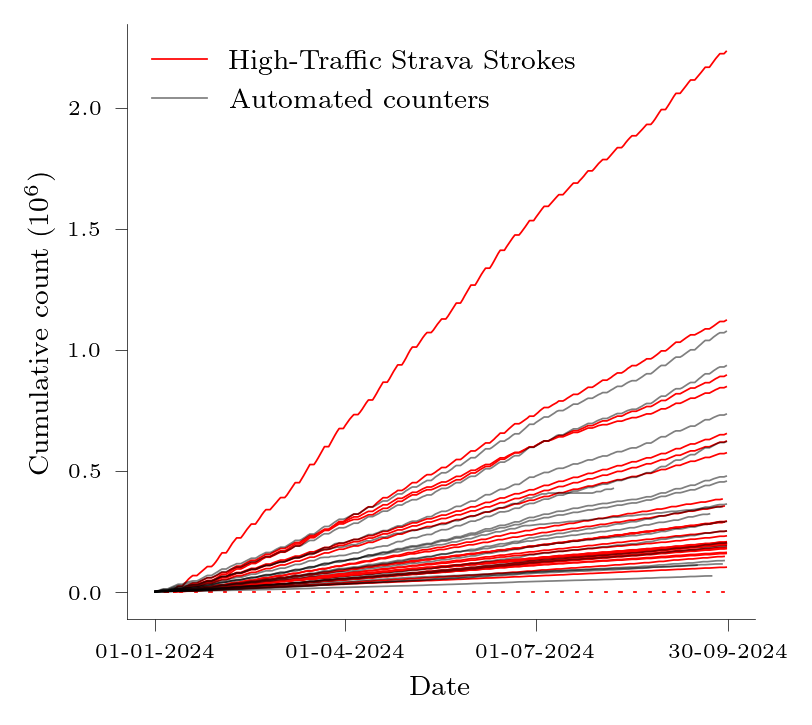

In [ ]:
fig_cumulative_sums,ax_cumulative_sums = plt.subplots(figsize = (cm_to_inches(FULL_PAGE_WIDTH_CM)/2,cm_to_inches(FULL_PAGE_WIDTH_CM/2.25)),dpi = 250,constrained_layout = True)

## Extrapolated vs Counters

for i, key in enumerate(cumulative_sums_predicted.keys()):
    if i ==0:
        ax_cumulative_sums.plot(np.array(cumulative_sums_predicted[key])/1e6,linewidth = 0.5,color ='red',label ='High-Traffic Strava Strokes')
    else:
        ax_cumulative_sums.plot(np.array(cumulative_sums_predicted[key])/1e6,linewidth = 0.5,color ='red')

for j,key in enumerate(cumulative_sums_counters.keys()):
    if j ==0:
        ax_cumulative_sums.plot(np.array(cumulative_sums_counters[key])/1e6,linewidth = 0.5,color ='black',alpha = 0.5,label ='Automated counters')
    else:
        ax_cumulative_sums.plot(np.array(cumulative_sums_counters[key])/1e6,linewidth = 0.5,color ='black',alpha = 0.5)

_ = ax_cumulative_sums.set_xticks([0,91,182,274],['01-01-2024','01-04-2024','01-07-2024',"30-09-2024"],fontsize = 6)


ax_cumulative_sums.yaxis.get_offset_text().set_fontsize(8)

ax_cumulative_sums.spines['top'].set_visible(False)
ax_cumulative_sums.spines['right'].set_visible(False)

ax_cumulative_sums.spines['bottom'].set_linewidth(0.2)
ax_cumulative_sums.spines['left'].set_linewidth(0.2)

ax_cumulative_sums.set_ylabel("Cumulative count ($10^6)$", fontdict=label_font)
ax_cumulative_sums.set_xlabel("Date", fontdict=label_font)

ax_cumulative_sums.legend(loc='upper left',fontsize = legend_font['fontsize'],frameon = False,edgecolor = 'black')


ax_cumulative_sums.tick_params(which='both',labelsize=6,width=0.2)

fig_cumulative_sums.savefig(f"{SAVE_PATH}/figures/main/figure_6b_cumulative_counts_comparison.pdf")

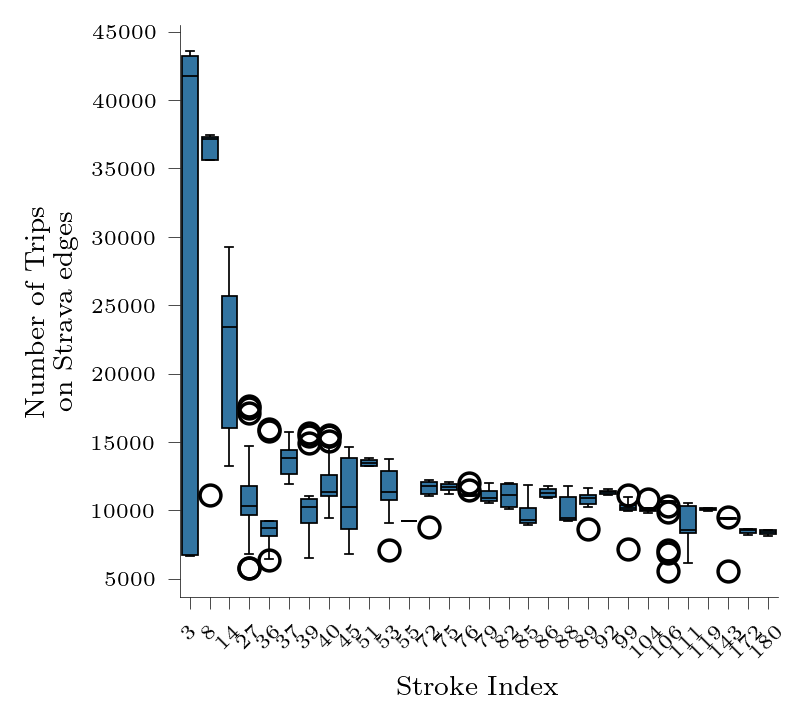

In [67]:
fig,ax = plt.subplots(1,1,figsize = (cm_to_inches(FULL_PAGE_WIDTH_CM)/2,cm_to_inches(FULL_PAGE_WIDTH_CM/2.25)),dpi = 250,constrained_layout = True)
sns.boxplot(data = top30_edges,x = 'stroke_index',y = 'strava_trips',ax = ax,linecolor='black',linewidth=0.5)

ax.set_ylabel("Number of Trips\n on Strava edges", fontdict=label_font)
ax.set_xlabel("Stroke Index", fontdict=label_font)

ax.tick_params(which='both',labelsize=6,width = 0.2)

ax.tick_params(axis='x', rotation=45)


ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.spines['bottom'].set_linewidth(0.2)
ax.spines['left'].set_linewidth(0.2)

fig.savefig(f"{SAVE_PATH}/figures/main/figure_6c_boxplot_stroke_trip_counts.pdf", dpi = 250, bbox_inches='tight')

In [89]:
length_infra = 0
for row in bike_infra_separated.iterrows():
    infra_type = row[1]['type_nl']
    if infra_type in ['Tweerichtingsfietspad','Tweerichtings gedeeld voet/fietspad']:
        length_infra += row[1]['geometry'].length*2
    else:
        length_infra += row[1]['geometry'].length

In [91]:
missing_links_strokes = [3, 8, 106, 89, 76, 85, 86, 92, 119, 27, 37, 82, 51]
total_length_missing_link = 0
total_length_independent_high_traffic = 0

total_length_current_infrastructure = length_infra/1000

for row in top30_strokes.iterrows():

    index = row[0]
    if index in missing_links_strokes:
        data = row[1]
        total_length_missing_link += data.geometry.length
    else:
        data = row[1]
        total_length_independent_high_traffic += data.geometry.length

print(f"Total length of missing links: {total_length_missing_link/1000} km (\%: {((total_length_missing_link/1000)/total_length_current_infrastructure)*100:.2f})")
print(f"Total length of independent high traffic: {total_length_independent_high_traffic/1000} km (\%: {((total_length_independent_high_traffic/1000)/total_length_current_infrastructure)*100:.2f})")

Total length of missing links: 9.36104470911657 km (\%: 2.46)
Total length of independent high traffic: 11.507206597775925 km (\%: 3.03)
